## Day 25 Lecture 2 Assignment

In this assignment, we will extend a previous binary model to a multinomial case with three classes. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [65]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

In [4]:
def remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f'Deleted {colname} from dataset.')
                    del dataset[colname]

    return dataset

In [5]:
soccer_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv')

In [6]:
soccer_data.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,79,83,94,94,88,95,90,94,82,56,83,66,80,54,41,87,89,86,91,34,27,22


Our response for our logistic regression model is going to be a new column, "RankingTier", that contains three categories:

- High: Overall score > 75
- Middle: Overall score between 65 and 75
- Low: Overall score < 65

In [12]:
# answer goes here
soccer_data['RankingTier'] = np.where((soccer_data['Overall'] >= 75), 'High', (np.where((soccer_data['Overall'] < 75) & (soccer_data['Overall'] >= 65), 'Middle', 'Low')))
soccer_data



,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,RankingTier
0,158023,L. Messi,94,84,95,70,90,86,97,93,94,87,96,91,86,91,95,95,85,68,72,59,94,48,22,94,94,75,96,33,28,26,High
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,76,77,94,89,91,87,96,70,95,95,88,79,93,63,29,95,82,85,95,28,31,23,High
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,87,78,95,94,90,96,94,84,80,61,81,49,82,56,36,89,87,81,94,27,24,33,High
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,83,91,91,78,76,79,91,77,91,63,90,75,91,76,61,87,94,79,88,68,58,51,High
4,183277,E. Hazard,91,81,84,61,89,80,95,83,79,83,94,94,88,95,90,94,82,56,83,66,80,54,41,87,89,86,91,34,27,22,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16117,238813,J. Lundstram,47,34,38,40,49,25,42,30,34,45,43,54,57,60,49,76,43,55,40,47,38,46,46,39,52,43,45,40,48,47,Low
16118,243165,N. Christoffersson,47,23,52,52,43,36,39,32,20,25,40,41,39,38,40,52,41,47,43,67,42,47,16,46,33,43,42,22,15,19,Low
16119,241638,B. Worman,47,25,40,46,38,38,45,38,27,28,44,70,69,50,47,58,45,60,55,32,45,32,15,48,43,55,41,32,13,11,Low
16120,246268,D. Walker-Rice,47,44,50,39,42,40,51,34,32,32,52,61,60,52,21,71,64,42,40,48,34,33,22,44,47,50,46,20,25,27,Low


The next few steps until model training are the same as before: identify and remove highly correlated features, and split the data into a training set (80%) and a test set (20%).

In [15]:
# remove highly correlated features
remove_correlated_features(soccer_data, 0.90)
soccer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16122 entries, 0 to 16121
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               16122 non-null  int64 
 1   Name             16122 non-null  object
 2   Overall          16122 non-null  int64 
 3   Crossing         16122 non-null  int64 
 4   Finishing        16122 non-null  int64 
 5   HeadingAccuracy  16122 non-null  int64 
 6   ShortPassing     16122 non-null  int64 
 7   Volleys          16122 non-null  int64 
 8   Dribbling        16122 non-null  int64 
 9   Curve            16122 non-null  int64 
 10  FKAccuracy       16122 non-null  int64 
 11  LongPassing      16122 non-null  int64 
 12  BallControl      16122 non-null  int64 
 13  Acceleration     16122 non-null  int64 
 14  SprintSpeed      16122 non-null  int64 
 15  Agility          16122 non-null  int64 
 16  Reactions        16122 non-null  int64 
 17  Balance          16122 non-null

In [25]:
X = soccer_data.drop(['ID', 'Name', 'Overall', 'RankingTier'], axis=1)
Y = soccer_data['RankingTier']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Fit a multinomial logistic regression model (it's a different model than the binary one) using the statsmodels package and print out the coefficient summary. What is the "reference" tier chosen by the model? How do we interpret the coefficients - for example, how does the intepretation of the "Reactions" coefficient for RankingTier=Low differ from the "Reactions" coefficient for RankingTier=Middle?

In [26]:
# answer goes here
import statsmodels.api as sm
import pandas.util.testing as tm

X_train_const = sm.add_constant(X_train)

sm_model = sm.MNLogit(Y_train, X_train_const).fit() 
print(sm_model.summary()) 
print(sm_model.summary2())

Optimization terminated successfully.
         Current function value: 0.363389
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:            RankingTier   No. Observations:                12897
Model:                        MNLogit   Df Residuals:                    12841
Method:                           MLE   Df Model:                           54
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                  0.6244
Time:                        19:53:35   Log-Likelihood:                -4686.6
converged:                       True   LL-Null:                       -12476.
Covariance Type:            nonrobust   LLR p-value:                     0.000
   RankingTier=Low       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 94.5634      1.937     48.825      0.000      90.767      98.359
Cros

To evaluate test error using cross-validation, we will switch back to scikit-learn. Estimate the test error of this multinomial logistic regression model using 10-fold CV.

Note: scikit-learn's LogisticRegression() function can handle both binary and multinomial regression, and it is automatically able to determine which is appropriate based on the y_train array that is passed. You should be able to reuse previous code with minimal changes required.

As we did in the previous exercise, train a multinomial logistic regression on the training data, make predictions on the 20% holdout test data, then:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Comment on the performance of the model.

In [51]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, Y_train)

test_score = lr.score(X_test, Y_test)
train_score = lr.score(X_train, Y_train)
print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8393424827479259
Score on test data:  0.8458914728682171


In [59]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, Y_train)
dummy.score(X_test,Y_test)

0.5100775193798449

We see a slightly better score on the test data than on the training, indicating that we might have some underfitting occuring. But by comparison to our dummy scores, our model is scoring well above the dummyClassifier output.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr_clf = LogisticRegression(max_iter=10000)
cv_scores = cross_val_score(lr_clf, X_train, Y_train, cv=10)

print('Accuracy scores for the 10 folds: ', lr_cv_scores)
print('Mean cross validatiion score: {:.3f}'.format(np.mean(cv_scores)))

Accuracy scores for the 10 folds:  [0.84651163 0.84496124 0.84883721 0.85658915 0.82403101 0.83643411
 0.82403101 0.83708301 0.83087665 0.83397983]
Mean cross validatiion score: 0.838


In [54]:
# make predictions on the 20% test data
from sklearn.metrics import classification_report
predictions = lr.predict(X_test)
print(classification_report(Y_test, predictions, target_names=['Low', 'Middle', 'High']))

              precision    recall  f1-score   support

         Low       0.82      0.78      0.80       340
      Middle       0.87      0.83      0.85      1240
        High       0.83      0.87      0.85      1645

    accuracy                           0.85      3225
   macro avg       0.84      0.83      0.83      3225
weighted avg       0.85      0.85      0.85      3225



In [60]:
dummy_report = classification_report(Y_test, dummy.predict(X_test), target_names=['Low', 'Middle', 'High'])
print(dummy_report)

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       340
      Middle       0.00      0.00      0.00      1240
        High       0.51      1.00      0.68      1645

    accuracy                           0.51      3225
   macro avg       0.17      0.33      0.23      3225
weighted avg       0.26      0.51      0.34      3225



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
confusion = confusion_matrix(Y_test, predictions, labels=['Low', 'Middle', 'High'])
print(confusion)

[[1026  214    0]
 [ 152 1436   57]
 [   0   74  266]]


In [62]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

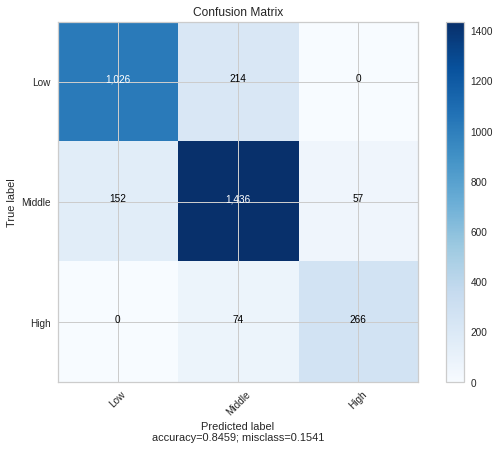

In [63]:
plot_confusion_matrix(cm=confusion, target_names = ['Low', 'Middle', 'High'], title = 'Confusion Matrix', normalize=False)

In [67]:
Y_bin = pd.get_dummies(Y_test)
Y_pred_prob = lr.predict_proba(X_test)
lr.classes_

array(['High', 'Low', 'Middle'], dtype=object)

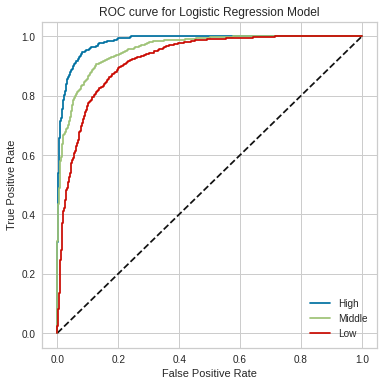

In [68]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
fpr1, tpr1, thresholds = roc_curve(Y_bin['High'], Y_pred_prob[:,0])
line0, = plt.plot(fpr1, tpr1, label='High')

fpr2, tpr2, thresholds = roc_curve(Y_bin['Low'], Y_pred_prob[:,1])
line1, = plt.plot(fpr2, tpr2, label='Middle')

fpr3, tpr3, thresholds = roc_curve(Y_bin['Middle'], Y_pred_prob[:,2])
line2, = plt.plot(fpr3, tpr3, label='Low')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()